Imports

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


import zipfile


zip_path = 'Housing Price Regression.zip'


# Open the ZIP file and check its contents

with zipfile.ZipFile(zip_path, 'r') as z:
    print(z.namelist())  # Lists all files inside the ZIP


['house_price_regression_dataset.csv']


Read In Data

In [2]:
# Assuming it contains a CSV file, read it directly
csv_filename = "house_price_regression_dataset.csv"  # Replace with actual file name
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

# Display the first few rows
df.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


Print out Column Names

In [3]:
df.columns

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')

Length and width of File

In [4]:
df.shape

(1000, 8)

Summary Statstics

In [5]:
df.describe()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2815.422000,2.990000,1.973000,1986.550000,2.778087,1.022000,5.615000,6.188610e+05
std,1255.514921,1.427564,0.820332,20.632916,1.297903,0.814973,2.887059,2.535681e+05
min,503.000000,1.000000,1.000000,1950.000000,0.506058,0.000000,1.000000,1.116269e+05
25%,1749.500000,2.000000,1.000000,1969.000000,1.665946,0.000000,3.000000,4.016482e+05
50%,2862.500000,3.000000,2.000000,1986.000000,2.809740,1.000000,6.000000,6.282673e+05
75%,3849.500000,4.000000,3.000000,2004.250000,3.923317,2.000000,8.000000,8.271413e+05
max,4999.000000,5.000000,3.000000,2022.000000,4.989303,2.000000,10.000000,1.108237e+06


Check for the presence of any nulls

In [15]:
df.isnull().values.any()


np.False_

Determine Field Data Types. Might need to convert types.

In [6]:
print(df.dtypes)

Square_Footage            int64
Num_Bedrooms              int64
Num_Bathrooms             int64
Year_Built                int64
Lot_Size                float64
Garage_Size               int64
Neighborhood_Quality      int64
House_Price             float64
dtype: object


In [7]:
target_column = "House_Price"

Plot all Predictor Variables to get Initial Look

Square Footage appears to be factor affecting House Price. Other Features seem to have less linear influence. Tree-based models (like Random Forest, XGBoost) do not require linear relationships.

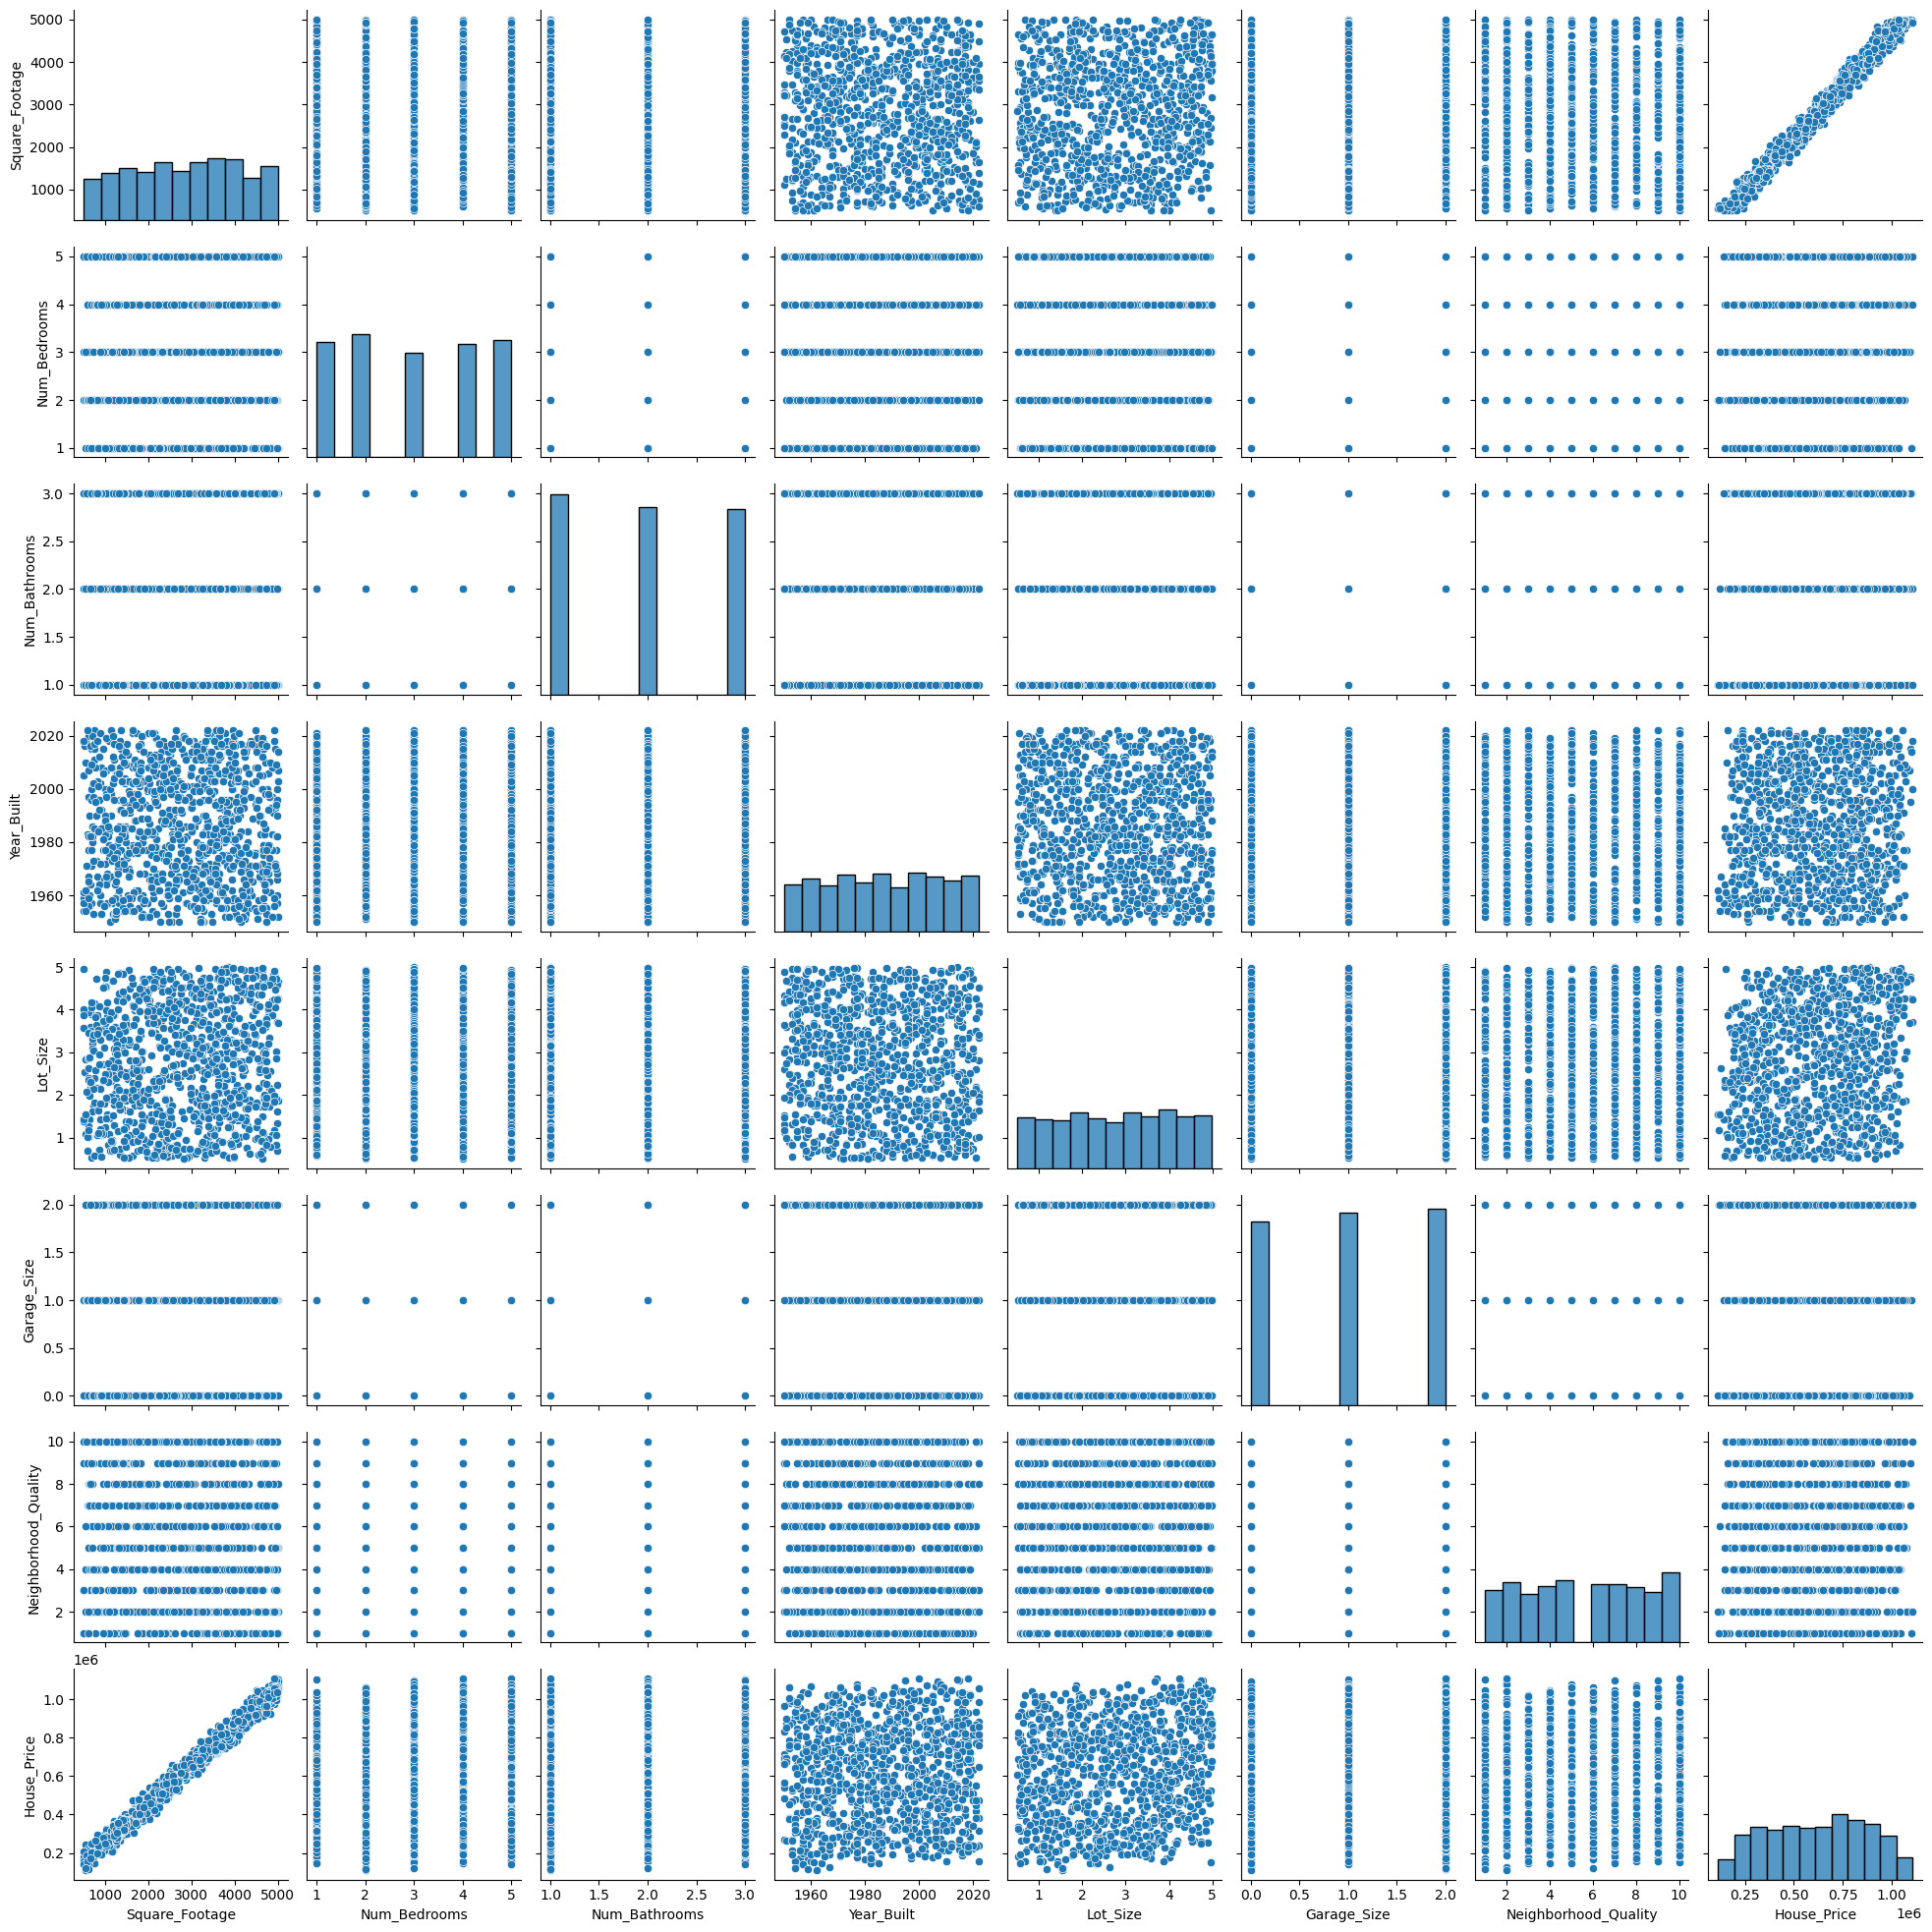

In [8]:
sns.pairplot(df)

Some features just don’t have much signal.

Check the variance of fields:

In [ ]:
for col in ['Num_Bedrooms', 'Num_Bathrooms', 'Garage_Size', 'Neighborhood_Quality','Lot_Size','Year_Built']:
    print(f"{col}: Unique values = {df[col].nunique()}, Value counts:\n{df[col].value_counts()}\n")


Num_Bedrooms: Unique values = 5, Value counts:
Num_Bedrooms
2    215
5    205
1    201
4    197
3    182
Name: count, dtype: int64

Num_Bathrooms: Unique values = 3, Value counts:
Num_Bathrooms
1    350
2    327
3    323
Name: count, dtype: int64

Garage_Size: Unique values = 3, Value counts:
Garage_Size
2    343
1    336
0    321
Name: count, dtype: int64

Neighborhood_Quality: Unique values = 10, Value counts:
Neighborhood_Quality
10    123
5     109
2     105
7     102
6     101
4      99
8      97
1      91
9      88
3      85
Name: count, dtype: int64

Lot_Size: Unique values = 1000, Value counts:
Lot_Size
3.108790    1
0.599637    1
4.753014    1
3.634823    1
2.730667    1
           ..
4.781489    1
3.978440    1
3.555040    1
3.941604    1
1.014286    1
Name: count, Length: 1000, dtype: int64

Year_Built: Unique values = 73, Value counts:
Year_Built
1996    24
1977    22
2008    21
1983    21
2017    21
        ..
1980     8
2001     8
2020     8
1951     6
1963     5
Name: co

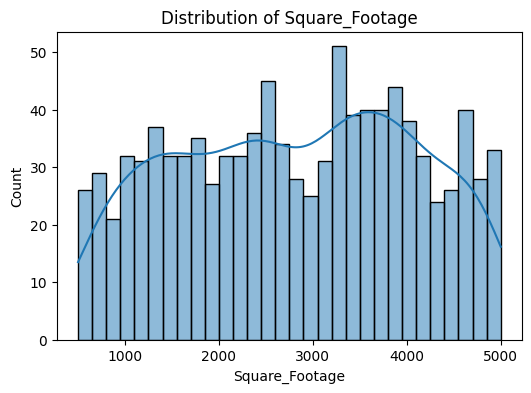

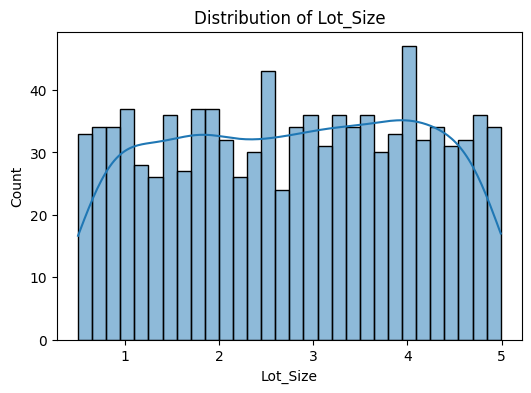

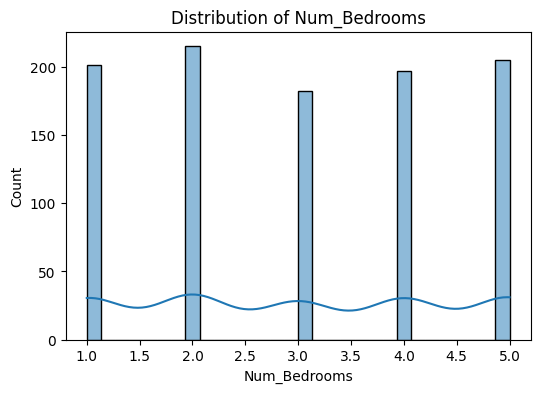

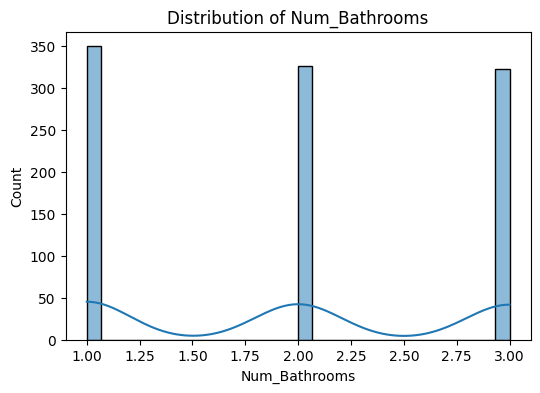

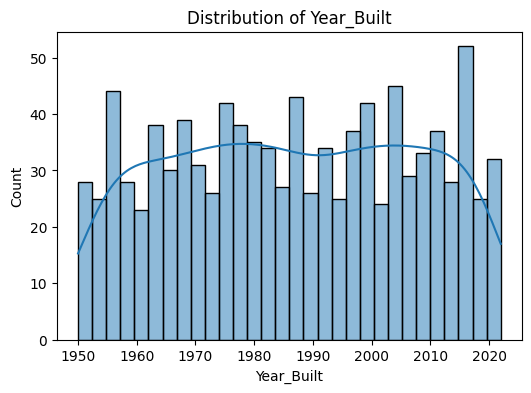

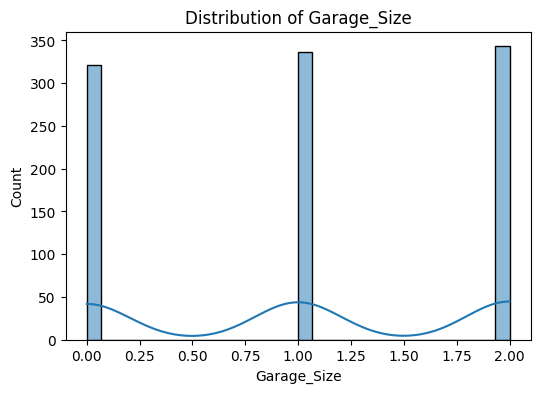

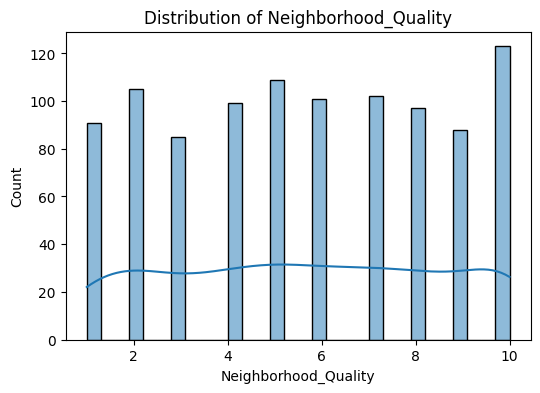

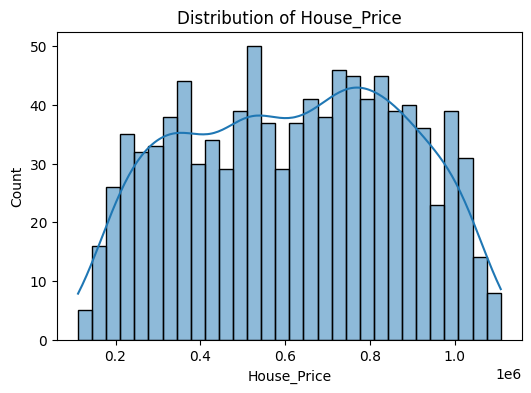

In [53]:

for col in ['Square_Footage', 'Lot_Size', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Garage_Size', 'Neighborhood_Quality','House_Price',  ]:  # Replace with your predictor variables
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


Q-Q plots (Quantile-Quantile plot) to assess if your data is normally distributed *A key assumption in Linear Regression and other statistical models

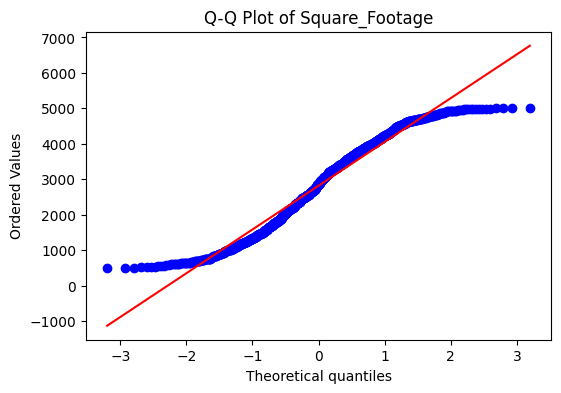

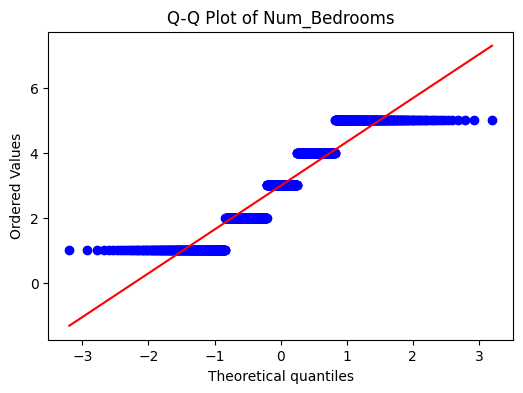

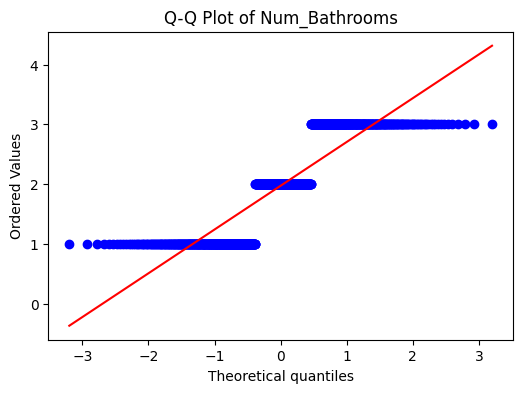

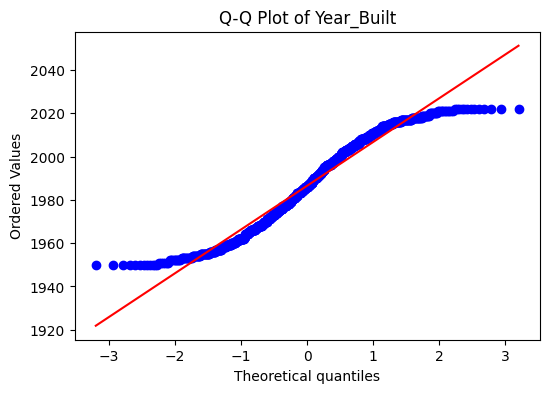

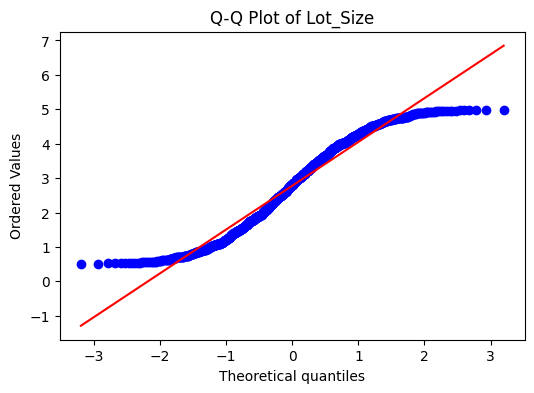

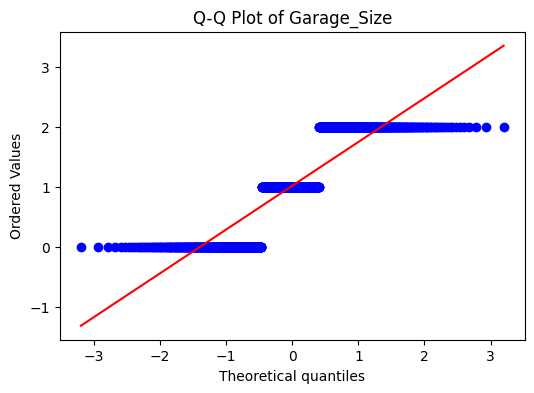

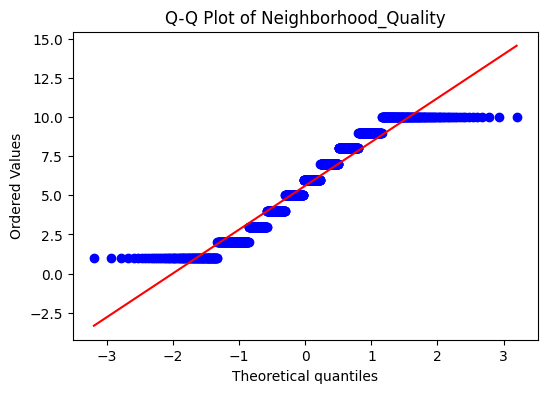

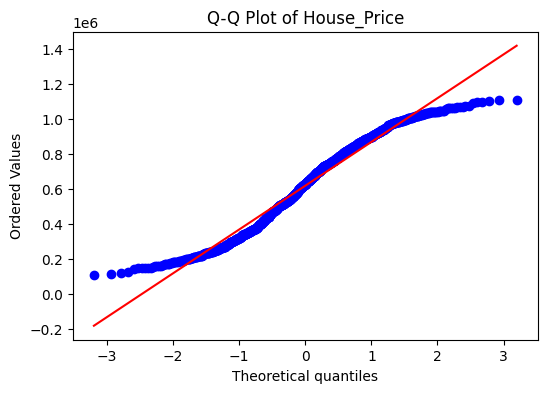

In [54]:
import matplotlib.pyplot as plt
import scipy.stats as stats

for col in df.columns:  # Loop through predictor variables
    plt.figure(figsize=(6, 4))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.show()


Reviewing Correlations to House Price

In [48]:
df.corr()["House_Price"]


Square_Footage          0.991261
Num_Bedrooms            0.014633
Num_Bathrooms          -0.001862
Year_Built              0.051967
Lot_Size                0.160412
Garage_Size             0.052133
Neighborhood_Quality   -0.007770
House_Price             1.000000
Name: House_Price, dtype: float64

Investigate Multicollinearity

If Square Footage is highly correlated with Bedrooms then this features might not contribute much independently.

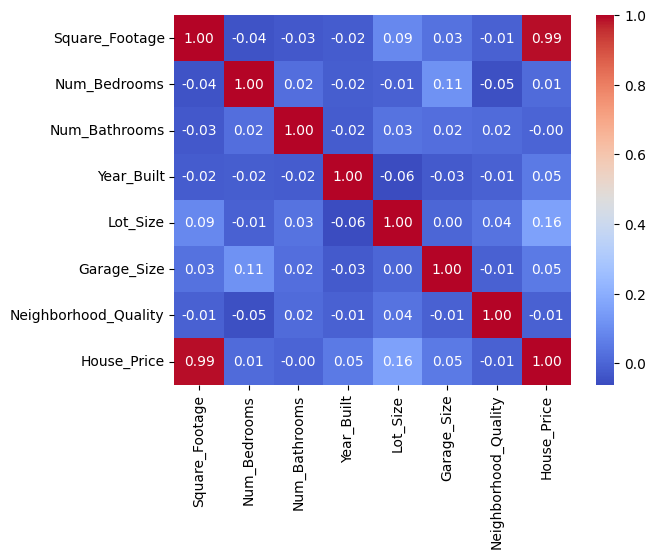

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


It would be nice to have features such as "Location" or "Condition"

Box Plots to Identify Outliers


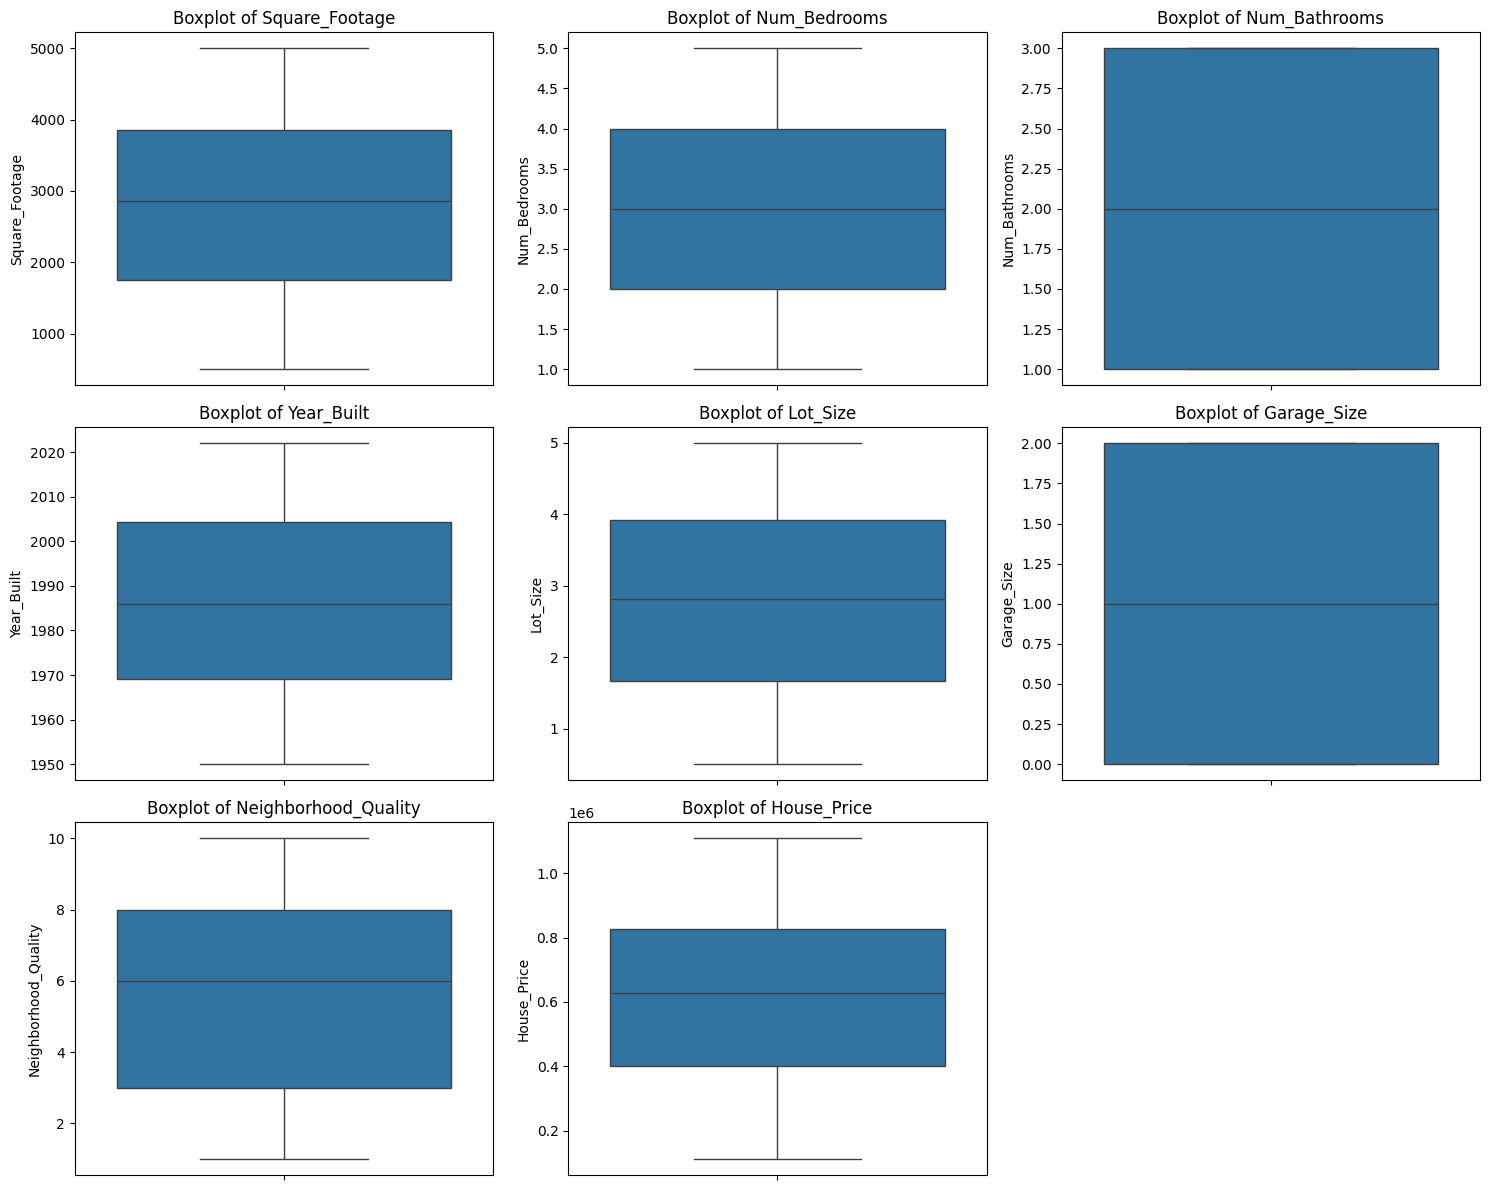

In [55]:
# Define the number of rows and columns for the grid layout
num_columns = 3  # Adjust based on preference
num_features = len(df.columns)
num_rows = int(np.ceil(num_features / num_columns))

# Create subplots for boxplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten in case of fewer plots than grid spots

# Plot each feature separately in the grid
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i])  # Box plot for each variable
    axes[i].set_title(f"Boxplot of {col}")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()